# Проект: "Компьютерные игры"

## Введение

Из открытых источников нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### План работ

1) Откроем файл с данными и изучим общую информацию.

2) Подготовим данные.

3) Проведем исследовательский анализ данных:
- Сколько игр выпускалось в разные годы.
- Как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.
- Определеим, за какой характерный срок появляются новые и исчезают старые платформы.
- Определим несколько потенциально прибыльных платформ.
- Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.
- Определим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.
- Посмотрим на общее распределение игр по жанрам.

4) Составим портрет пользователя каждого региона.

5) Проверим гипотезы о равенстве средних.

## Шаг 1. Чтение файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('games.csv')


## Шаг 2. Подготовка данных

Приведем названия столбцов к нижнему регистру

In [4]:
data = data.rename(columns={'Name':'name','Platform':'platform','Year_of_Release':'year','Genre':'genre','NA_sales':'na_sales',\
                           'EU_sales':'eu_sales','JP_sales':'jp_sales','Other_sales':'other_sales','Critic_Score':'critic_score',\
                           'User_Score':'user_score','Rating':'rating'})

data.columns

Index(['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales', 'jp_sales',
       'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Заполним пропуски в значениях нулями - оценка пользователей, оценка критиков, год. Приведем значения к нужным типам: год - целочисленный тип, оценки - вещественнынй.

In [5]:
data['user_score'] = data['user_score'].fillna('0')
data['critic_score'] = data['critic_score'].fillna('0')
data['year'] = data['year'].fillna('0')

data['user_score'] = data['user_score'].replace('tbd','0')

data['name'] = data['name'].fillna('n/a')
data = data.query('name != "n/a" and year != 0').reset_index()

data['year'] = data['year'].astype('int')
data['user_score'] = data['user_score'].astype('float')
data['critic_score'] = data['critic_score'].astype('float')



Добавим столбец с суммарными продажами

In [6]:
data['sales_total'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

## Шаг 3. Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы

Text(0, 0.5, 'Количество игр')

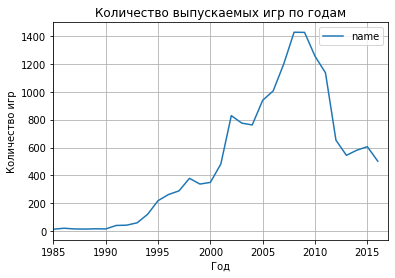

In [7]:
data.pivot_table(index=('year'),values='name',aggfunc=('count')).plot(xlim=(1985, 2017), grid=True)
plt.title('Количество выпускаемых игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

Text(0, 0.5, 'Доход с продаж')

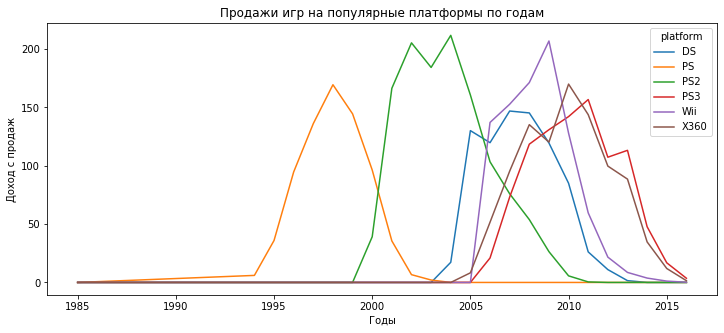

In [8]:
# выберем платформы с наибольшми продажами
data2 = (data.pivot_table(index=('platform'), values='sales_total',aggfunc=('sum')).
        sort_values(by='sales_total', ascending=False).
        query('sales_total > 500'))

# на основе предыдущего списка популярных платформ, создадим датасет и построим распределение по годам
data3 = (data.query('platform in @data2.index and year != 0').
         pivot_table(index='year',columns='platform',values='sales_total',aggfunc='sum',fill_value=0))

data3.plot(figsize=(12,5))
plt.title('Продажи игр на популярные платформы по годам')
plt.xlabel('Годы')
plt.ylabel('Доход с продаж')


Как видно на графике, в среднем платформа присутствует на рынке около 10 лет. На примере PlayStation видно, что новое поколение данной платформы появлялось на спаде популярности предыдущей версии. Таким образом, PS удалось сохранить одну из топовых позиций на рынке, выпуская новые версии платформы.

Теперь рассмотрим данные за соответствующий актуальный период. В качестве актуального периода возьмем 5 лет - с 2010 по 2015 год. Данные за предыдущие годы опустим.

In [9]:
df = data.query('year >= 2010 and year < 2016').copy()
df.sample(5)

,index,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
8479,8480,Dengeki Bunko Fighting Climax,PS3,2014,Fighting,0.05,0.00,0.09,0.01,66.0,8.2,T,0.15
600,600,Super Mario All-Stars: Limited Edition,Wii,2010,Platform,0.99,0.52,0.92,0.14,0.0,0.0,NaN,2.57
16370,16372,Curse of the Amsterdam Diamond,DS,2012,Puzzle,0.00,0.01,0.00,0.00,0.0,0.0,NaN,0.01
2568,2569,Final Fantasy X / X-2 HD Remaster,PSV,2013,Role-Playing,0.16,0.24,0.28,0.12,86.0,8.5,T,0.80
15657,15659,Earth Seeker,Wii,2011,Role-Playing,0.00,0.00,0.02,0.00,0.0,0.0,NaN,0.02


Рассмотрим, какие платформы лидируют по продажам. Для понимания общей картины, рассмотрим данные по 3 годам: 2010, 2013, 2015.

In [10]:
df.query('year == 2010 or year == 2013 or year == 2015')\
.pivot_table(index='platform', columns = 'year', values='sales_total', aggfunc = 'sum', fill_value=0)

year,2010,2013,2015
platform,,,
3DS,0.00,56.57,27.78
DS,85.02,1.54,0.00
PC,24.28,12.38,8.52
PS2,5.64,0.00,0.00
PS3,142.17,113.25,16.82
PS4,0.00,25.99,118.90
PSP,35.04,3.14,0.12
PSV,0.00,10.59,6.25
Wii,127.95,8.59,1.14


Наиболее перспективными платфрмами являются платформы PlayStation 4.

Платформа XOne набирает популярность.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

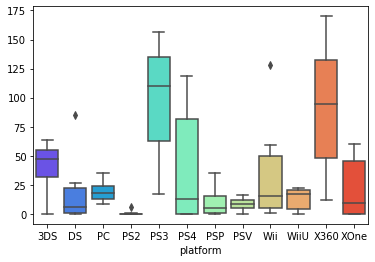

In [11]:
import seaborn as sns
  
sns.boxplot(data=df.pivot_table(index='year',columns='platform', values='sales_total', \
                                aggfunc = 'sum', fill_value=0), palette='rainbow',orient='v')


Платформы PS3 и X360 оказались наиболее прибыльными с точки зрения продаж игр.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

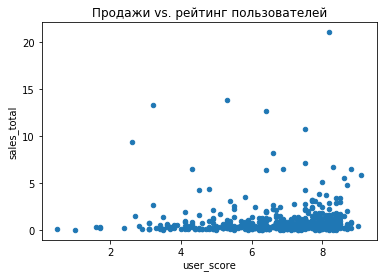

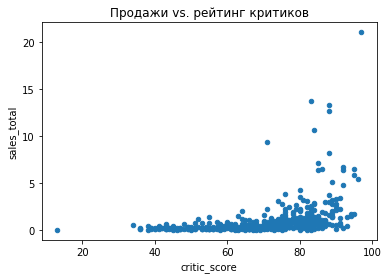

In [12]:
# создадим датафрейм с данными по платформе PS3, чтоб проверить зависимость продаж от оценки критиков

df1 = df.query('platform =="PS3"')[['name','critic_score','user_score','sales_total']]

df1.query('user_score > 0')['user_score'].corr(df['sales_total'])
df1.query('critic_score > 0')['critic_score'].corr(df['sales_total'])
df1.query('critic_score > 0 and user_score >0')['critic_score'].corr(df['user_score'])

df1.query('user_score > 0').plot(y='sales_total', x='user_score', kind='scatter', title='Продажи vs. рейтинг пользователей')
df1.query('critic_score > 0').plot(y='sales_total', x='critic_score', kind='scatter', title='Продажи vs. рейтинг критиков')

Как правило, игры с хорошим рейтингом имеют хорошие продажи, значит существует  зависимость между оценками пользователей/критиков и продажами игр.

Посмотрим на зависимость рейтинга и продаж в отношении всех игр на разных платформах.

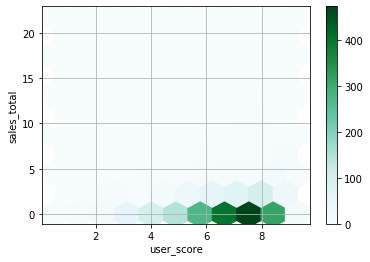

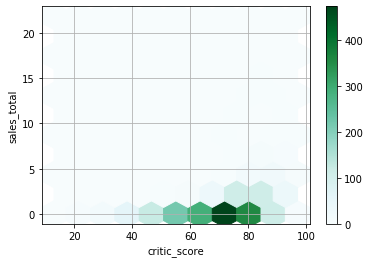

In [13]:
df.query('user_score > 0')['user_score'].corr(df['sales_total'])
df.query('critic_score > 0')['critic_score'].corr(df['sales_total'])
df.query('critic_score > 0 and user_score >0')['critic_score'].corr(df['user_score'])

df.query('user_score > 0').plot(y='sales_total', x='user_score', kind='hexbin', gridsize=10, sharex=False, grid=True)
df.query('critic_score > 0').plot(y='sales_total', x='critic_score', kind='hexbin', gridsize=10, sharex=False, grid=True)

По графикам видно, что игры с рейтингом выше среднего имеют хорошие продажи. Это неудивительно, как правило, хорошие игры одинаково ценятся и пользователями (положительно сказывается на продажах), и критиками (положительно сказывается на рейтинге).

Посмотрим на общее распределение игр по жанрам. Сделаем выводы о самых прибыльных жанрах.

In [14]:
df.pivot_table(index='genre', values = 'sales_total', aggfunc = ('sum','mean', 'count')).sort_values(by='sum', ascending=False)

,count,mean,sum
genre,,,
Action,1317,0.488216,642.98
Shooter,363,1.216309,441.52
Sports,527,0.578558,304.90
Role-Playing,514,0.578016,297.10
Misc,544,0.426397,231.96
Racing,213,0.562864,119.89
Platform,138,0.844130,116.49
Fighting,183,0.421421,77.12
Simulation,199,0.351055,69.86


Самыми популярными жанрами являются игры типа Action - они лидирует и по количеству игр, и по продажам. Затем идут стрелялки и спортивный жанр. Стрелялки, в свою очередь, хоть и не такие многочисленные по количеству, но продажи превышают спортивный жанр (много игр, немного продаж).

## Шаг 4. Определение портрета пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5).
- Самые популярные жанры (топ-5).
- Определим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

AxesSubplot(0.135,0.125;0.755x0.755)
AxesSubplot(0.135,0.125;0.755x0.755)
AxesSubplot(0.135,0.125;0.755x0.755)


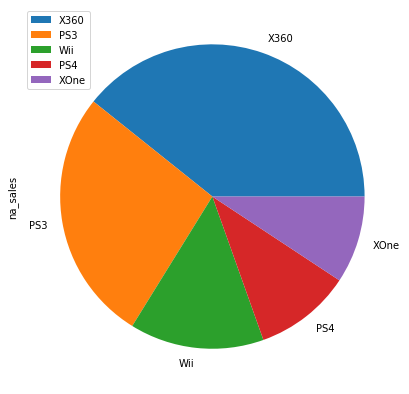

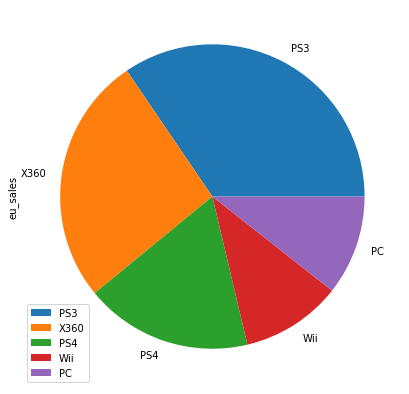

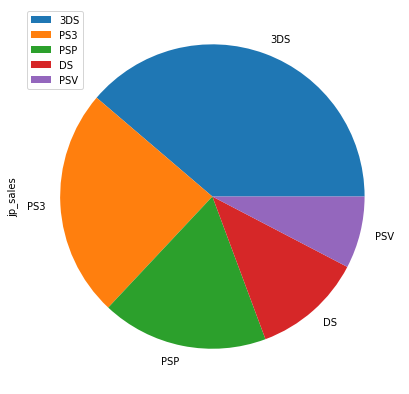

In [15]:
print(df.pivot_table(index='platform', values=('na_sales'), \
               aggfunc=('sum')).sort_values(by='na_sales', ascending=False).head(5).plot(kind='pie', y='na_sales', figsize=(7,7)))

print(df.pivot_table(index='platform', values=('eu_sales'), \
               aggfunc=('sum')).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='pie', y='eu_sales', figsize=(7,7)))

print(df.pivot_table(index='platform', values=('jp_sales'), \
               aggfunc=('sum')).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='pie', y='jp_sales', figsize=(7,7)))

В Америке пользователи предпочитают играть на платформе X360, второй по популярности платформой у них считается PS3. Обратная ситуация в Европе. А вот в Японии пользователи выбирают платоформу 3DS, затем уже PS3; а вот платформа X360 не входит в топ5 выбора пользователей в Японии.

AxesSubplot(0.135,0.125;0.755x0.755)
AxesSubplot(0.135,0.125;0.755x0.755)
AxesSubplot(0.135,0.125;0.755x0.755)


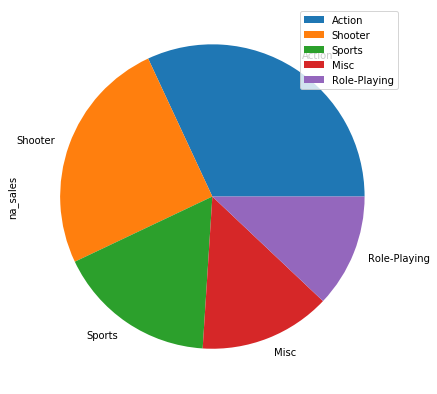

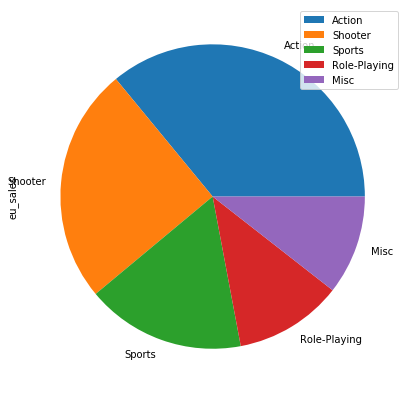

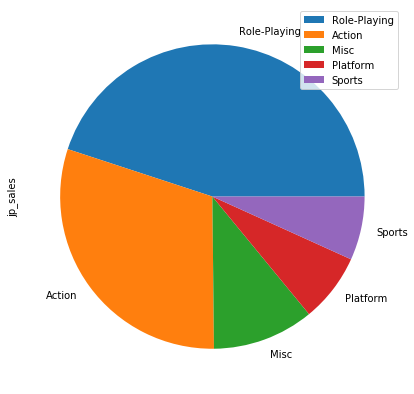

In [16]:
print(df.pivot_table(index='genre', values=('na_sales'), \
               aggfunc=('sum')).sort_values(by='na_sales', ascending=False).head(5).plot(kind='pie', y='na_sales', figsize=(7,7)))

print(df.pivot_table(index='genre', values=('eu_sales'), \
               aggfunc=('sum')).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='pie', y='eu_sales', figsize=(7,7)))

print(df.pivot_table(index='genre', values=('jp_sales'), \
               aggfunc=('sum')).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='pie', y='jp_sales', figsize=(7,7)))


Как видно из графиков, в Европе и Америке пользователи выбирают игры типа Action & Shooter. В то же самое время, в Японии самым популярным жанром игр является ролевая игра, затем Action. Игры типа Shooter вообще не пользуются популярностью в Японии. Вероятно, там пользователи предпочитают мирные игры.

In [17]:
df.pivot_table(index=('rating'), values = ('na_sales','eu_sales','jp_sales','other_sales'), aggfunc='sum'). \
sort_values(by='jp_sales')


,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
EC,0.00,0.00,1.13,0.07
RP,0.03,0.00,0.00,0.01
E10+,95.47,12.77,155.57,30.09
M,275.50,29.25,366.55,92.04
T,103.29,39.84,151.86,35.61
E,183.73,46.80,263.18,56.95


В Европе игры с рейтингом E наиболее популярны, затем идут игры с ретингами M & T.
В Америке самые популярные игры имеют рейтинг M, затем идут игры с рейтингами E & E10+.
В Японии игры с рейтингом E наиболее популярны, затем идут игры с ретингами T & M.

## Шаг 5. Проверка гипотез
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

In [18]:
import numpy as np
from scipy import stats as st

"""

Нулевая гипотеза: средние пользовательские рейтинги игр на платформах Xbox One и PC одинаковые
Альтернативная гипотеза: средние пользовательские рейтинги игр на платформах Xbox One и PC разные

"""

sample_1 = data.query('platform == "XOne" and user_score > 0')['user_score']
sample_2 = data.query('platform =="PC" and user_score > 0')['user_score']

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

print('средний рейтинг пользователей по играм на платоформе XOne:', sample_1.mean())
print('средний рейтинг пользователей по играм на платоформе PC:', sample_2.mean())
print('      ')

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, так как рейтинги игр на этих платформах PC & XOne отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 1.3896435533548819e-05
средний рейтинг пользователей по играм на платоформе XOne: 6.52142857142857
средний рейтинг пользователей по играм на платоформе PC: 7.062467532467546
      
Отвергаем нулевую гипотезу, так как рейтинги игр на этих платформах PC & XOne отличаются


In [19]:
"""

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports разные
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые

"""

sample_1 = data.query('genre == "Action" and user_score > 0')['user_score']
sample_2 = data.query('genre =="Sports" and user_score > 0')['user_score']

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

print('средний рейтинг пользователей по играм Action:', sample_1.mean())
print('средний рейтинг пользователей по играм Sports:', sample_2.mean())
print('      ')


if (results.pvalue > alpha):
    print("Отвергаем нулевую гипотезу, так как рейтинги жанров Actions & Sports практически не отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10406951359049141
средний рейтинг пользователей по играм Action: 7.054043715846988
средний рейтинг пользователей по играм Sports: 6.961196736174073
      
Отвергаем нулевую гипотезу, так как рейтинги жанров Actions & Sports практически не отличаются


# Выводы

При прогнозировании популярных и прибыльных игр, необходимо обращать внимание на платформу, для которой предназначена игра. Перспективными играми являются те, что выпускаются для платформ, которые набирают популряность. В среднем платформе должно быть около 2-3 лет. Далее платформа достигает пика популярности к 5 году, а потом популярность платформы и игр на нее начинает снижаться.

Однако есть серии платформ, которые переиздаются, например PlayStation нескольких поколений. Каждая из них имела хорошие продажи в свое время. Поэтому имеет смысл рассматривать новые поколения платформ, которые имели успешных предшественников.

Кроме того, нужно учитывать страну, для которой выпускается игра. Как оказалось, пользовательские предпочтения в Европе и Америке совершенно отличаются от предпочтений пользователей из Японии. Это следует учитывать.

Рейтинги критиков и пользователей в какой-то степени влияют на продажи игр. Поэтому стоит обращать внимание на критику в адрес игр и понять, что именно не нравится пользователям, чтоб учитывать в дальнейшем их предпочтения и замечания.